
\begin{center}
Chun-Yuan (Scott) Chiu
\end{center}
\begin{center}
chunyuac@andrew.cmu.edu
\end{center}

# 1. {-}

## 1.1 {-}

In [36]:
import pandas as pd
from sklearn.preprocessing import Normalizer

stock = pd.read_csv('stocksample.txt', sep='\t', index_col='symb')
stock = stock[stock.columns[3:]].T
stock = ((stock - stock.mean())/stock.std()).T
stock.head()

,2017-08-18,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-28,2017-08-29,2017-08-30,2017-08-31,...,2017-09-18,2017-09-19,2017-09-20,2017-09-21,2017-09-22,2017-09-25,2017-09-26,2017-09-27,2017-09-28,2017-09-29
symb,,,,,,,,,,,,,,,,,,,,,
NEWM,-1.042968,-1.093516,-0.461669,-0.916599,-0.714408,-0.512217,-0.360574,-0.588039,-0.310026,-0.310026,...,-0.208931,-0.183657,0.271273,0.347094,0.751476,1.484419,1.762431,2.065717,2.293182,2.217361
DMO,1.242230,1.457314,2.717065,1.430735,0.469868,0.686838,0.593853,1.120778,1.337757,1.244769,...,-0.986926,-1.048917,-0.893947,-0.753228,-0.534328,-0.721953,-0.659413,-1.034664,-0.784496,-0.190345
VMW,-2.564541,-2.379633,-1.650002,-1.535060,-1.425114,-0.947856,-0.463100,-0.400631,0.106613,0.391469,...,0.861233,0.786270,0.898713,0.633847,0.653838,0.246542,0.324004,0.668829,0.666330,0.663833
CCI,-0.342359,-0.046708,0.332222,0.482130,0.748633,0.852734,0.877722,0.865228,0.969329,1.456531,...,0.209164,-0.769930,-0.904402,-1.005252,-1.425465,-1.622966,-1.858284,-1.681795,-1.450677,-1.685995
MNK,-0.070881,-0.201274,0.295225,0.340361,0.861937,1.243087,1.228043,1.308285,1.423633,2.281225,...,-1.389865,-1.234395,-1.023758,-0.838198,-0.853243,-0.642607,-0.933487,-0.572396,-0.196260,0.420603


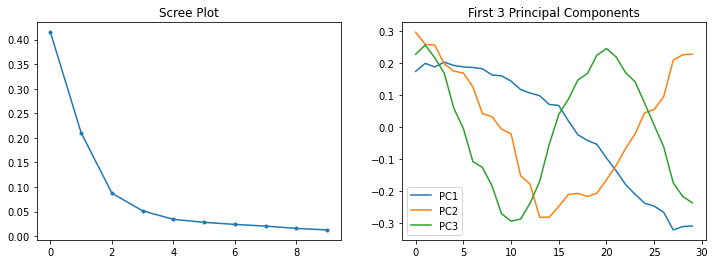

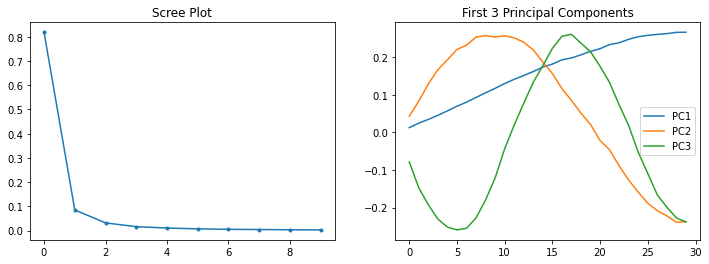

In [43]:
from scipy.stats import norm
from pandas import DataFrame, Series
import numpy as np

np.random.seed(0)
random_walk = DataFrame([norm.rvs(size=30).cumsum() for _ in range(1000)])

def pca_plots(data):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    
    pcaout = PCA(n_components=10).fit(data)
    Series(pcaout.explained_variance_ratio_).plot(style='.-', ax=ax[0])
    DataFrame(pcaout.components_[:3].T, columns=['PC1', 'PC2', 'PC3']).plot(ax=ax[1])
    
    ax[0].set_title('Scree Plot')
    ax[1].set_title('First 3 Principal Components')
    plt.show()

pca_plots(stock)    
pca_plots(random_walk)